# Dimension _'Property'_

## Introduction
### Hierarchies

This dimension has one hierarchy: _'property_type_category'_ > _'property_type'_.

In [1]:
# libraries
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import os
import psycopg2.extras

# set environment variable for psycog2 (for some systems)
os.environ["PGGSSENCMODE"] = "disable"

# get the stored passwords
f=open("credentials.txt", "rt")
pwd=f.readline().strip()  #di   password
hpwd=f.readline().strip() #home password
f.close()

## Exploratory data analysis

In [2]:
def missing_data(df, columns):
    """"""
    df_graph = df[columns]
    # missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Count', 'Percentage (%)'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percentage (%)', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    """"""
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    """"""
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')
        
# simple bar plot
def simple_plot(df,column):
    bx = sns.catplot(x=column,data=df, kind='count')
    (bx.set_axis_labels(column, "Count")
        .set_titles("{col_name} {col_var}")
        .despine(left=True))

### Missing data

#### Loading data

In [3]:
listings_al_file_path = '../data/listings_al.csv'
df_listings_al = pd.read_csv(listings_al_file_path)

C:\Users\joao_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


               Count  Percentage (%)
beds              58        0.003378
bedrooms           8        0.000466
bathrooms          5        0.000291
bed_type           0        0.000000
accommodates       0        0.000000
room_type          0        0.000000
property_type      0        0.000000


Text(0.5, 1.0, 'Property dimension missing values')

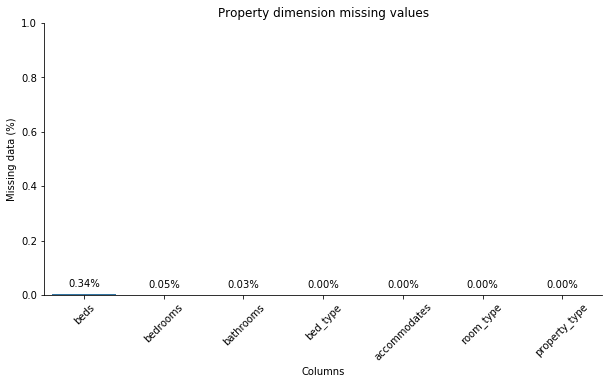

In [4]:
columns = ['property_type',
           'room_type',
           'accommodates',
           'bathrooms',
           'bedrooms',
           'beds',
           'bed_type']

ax = missing_data(df_listings_al,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Missing data (%)')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Property dimension missing values')

The detected missing data will be removed, as it constitutes a small percentage of the overall information.

## Preprocessing

The defined _'Property'_ dimension table is as follows. Price per meter squared was previously a column in this table, but data was lacking to determine that attribute at the property level, and therefore was removed.

<img src="../images/property_schema.png" align="center"/>

The ETL pipeline is described below:

![ETL pipeline](../images/Pipeline_property.png)

In [5]:
# load connection settings
from db_connection import dbconnection 

In [6]:
# test connection
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
conn.close()

In [7]:
def delete_null_rows(df,columns):
    """Removes all records with any empty cells from input DataFrame"""
    processed_df = df[columns].copy()
    total_rows = processed_df.shape[0]
    delete_rows = []
    
    if processed_df.isnull().values.any(): # if there are any null values in DataFrame, process DataFrame
        for index, row in enumerate(processed_df.itertuples(), start = 0):
            if (pd.Series(row).isnull().values.any()): # if row has any null value
                delete_rows.append(index) # add row index to delete list
    
    processed_df.drop(df.index[delete_rows], inplace = True) # delete rows fr
    processed_df = processed_df.reset_index().drop('index', axis = 1)
    print('DataFrame contains {} rows. Deleted {} rows ({}% of total rows)'.format(processed_df.shape[0], len(delete_rows), round(len(delete_rows)*100/total_rows, 2)))
    return processed_df

In [8]:
property_columns = ['id',
                    'property_type',
                    'room_type',
                    'accommodates',
                    'bathrooms',
                    'bedrooms',
                    'beds',
                    'bed_type']

df_property = delete_null_rows(df_listings_al,property_columns)

DataFrame contains 17097 rows. Deleted 71 rows (0.41% of total rows)


From `df_property`, we create `df_conv_fact`, which will be the table containing a record for each fact ID converted to the dimension format. `property_dimension` will be the _de facto_ property dimension from which we can correspond each fact ID record to the appropriate dimension foreign key according to its set of attributes.

### _'property_type_category'_

We start by creating _'property_type_category'_, a set of four categories from _'property_type'_.

In [9]:
def get_property_type_category(value):
# change 'property_type' to four categories, exclude exceptions
    if value in ["Apartment", "Serviced apartment", "Aparthotel","Loft"]:
        return 'Apartment'
    if value in ["House","Townhouse","Villa","Dome house","Vacation home","Lighthouse","Casa particular (Cuba)","Tiny house","Farm stay","Cottage"]:
        return 'House'
    if value in ["Guesthouse","Guest suite"]:
        return 'Guesthouse'
    if value in ["Hostel","Bed and breakfast","Boutique hotel","Hotel"]:
        return 'Hotel/Hostel'
    return None # for the case of missing or invalid values

### _'room_type'_

This attribute is already defined in satisfactory categories.

### _'accommodates'_

In [10]:
def get_accommodates(value):
# change 'property_type' to four categories, exclude exceptions
    if value in [1,2]: return 'Up to 2 guests'
    if value in [3,4]: return 'Up to 4 guests'
    if value in [5,6]: return 'Up to 6 guests'
    return 'Up to 7 guests or more' # no missing values in this column

### _'bathrooms'_

In [11]:
def get_bathrooms(value):
# change 'bathrooms' to five categories, exclude exceptions
    if value < 0.5: return 'No bathrooms'
    if value < 1.5: return '1 bathroom'
    if value < 2.5: return '2 bathrooms'
    if value < 3.5: return '3 bathrooms'
    if value >= 3.5: return '4+ bathrooms'
    return None # for the case of missing or invalid values

### _'bedrooms'_

In [12]:
def get_bedrooms(value):
# change 'bedrooms' to five categories, exclude exceptions
    if value == 0: return 'T0'
    if value == 1: return 'T1'
    if value == 2: return 'T2'
    if value == 3: return 'T3'
    if value >= 4: return 'T4+'
    return None # for the case of missing or invalid values

### _'beds'_

In [13]:
def get_beds(value):
# change 'beds' to five categories, exclude exceptions
    if value == 0: return 'No beds'
    if value == 1: return '1 bed'
    if value == 2: return '2 beds'
    if value == 3: return '3 beds'
    if value >= 4: return '4+ beds'
    return None # for the case of missing or invalid values

In [14]:
def convert_facts_property(df_non_null_facts):
    """Performs preprocessing in facts to a Property dimension format"""
    dimension = {}

    dimension['ID'] = [value for value in df_property['id']]
    dimension['property_type_category'] = [get_property_type_category(value) for value in df_property['property_type']]
    dimension['property_type'] = [value for value in df_property['property_type']]
    dimension['room_type'] = [value for value in df_property['room_type']]
    dimension['accommodates'] = [get_accommodates(value) for value in df_property['accommodates']]
    dimension['bathrooms'] = [get_bathrooms(value) for value in df_property['bathrooms']]
    dimension['bedrooms'] = [get_bedrooms(value) for value in df_property['bedrooms']]
    dimension['beds'] = [get_beds(value) for value in df_property['beds']]
    dimension['bed_type'] = [value for value in df_property['bed_type']]

    df_conv_facts = pd.DataFrame(dimension)
    df_conv_facts.index += 1
    df_conv_facts = delete_null_rows(df_conv_facts,df_conv_facts.columns) # removes any rows that during processing gained null values
    
    return df_conv_facts

In [15]:
df_conv_facts = convert_facts_property(df_property)

df_conv_facts

DataFrame contains 16626 rows. Deleted 471 rows (2.75% of total rows)


,ID,property_type_category,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,25659,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,1 bed,Real Bed
1,29248,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,2 beds,Real Bed
2,29396,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,1 bed,Real Bed
3,29720,Apartment,Apartment,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
4,27899698,Apartment,Apartment,Entire home/apt,Up to 4 guests,2 bathrooms,T2,2 beds,Real Bed
...,...,...,...,...,...,...,...,...,...
16621,41870065,Apartment,Apartment,Entire home/apt,Up to 2 guests,1 bathroom,T1,1 bed,Real Bed
16622,41879410,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,3 beds,Real Bed
16623,41882911,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,3 beds,Real Bed
16624,41879552,Apartment,Loft,Entire home/apt,Up to 2 guests,1 bathroom,T1,1 bed,Real Bed


`df_conv_facts` now contains all facts of interest converted to the appropriate dimension format.

## Creating the dimension table

In [16]:
create_table = """
CREATE TABLE IF NOT EXISTS Property (
    PROPERTY_ID SERIAL PRIMARY KEY NOT NULL,
    PROPERTY_TYPE_CATEGORY VARCHAR(30) CHECK (PROPERTY_TYPE_CATEGORY in ('Apartment', 'Guesthouse', 'House', 'Hotel/Hostel')) NOT NULL,
    PROPERTY_TYPE VARCHAR(30) CHECK (PROPERTY_TYPE in ('Apartment','Serviced apartment','Aparthotel','Loft','House','Townhouse','Villa','Dome house','Vacation home','Lighthouse','Casa particular (Cuba)','Tiny house','Farm stay','Cottage','Guesthouse','Guest suite','Hostel','Bed and breakfast','Boutique hotel','Hotel')) NOT NULL,
    ROOM_TYPE VARCHAR(30) CHECK (ROOM_TYPE in ('Entire home/apt', 'Private room', 'Hotel room', 'Shared room')) NOT NULL,
    ACCOMMODATES VARCHAR(30) CHECK (ACCOMMODATES in ('Up to 2 guests','Up to 4 guests','Up to 6 guests','Up to 7 guests or more')) NOT NULL,
    BATHROOMS VARCHAR(30) CHECK (BATHROOMS in ('No bathrooms','1 bathroom','2 bathrooms','3 bathrooms','4+ bathrooms')) NOT NULL,
    BEDROOMS VARCHAR(10) CHECK (BEDROOMS in ('T0','T1','T2','T3','T4+')) NOT NULL,
    BEDS VARCHAR(10) CHECK (BEDS in ('No beds','1 bed','2 beds','3 beds','4+ beds')) NOT NULL,
    BED_TYPE VARCHAR(30) CHECK (BED_TYPE in ('Real Bed', 'Pull-out Sofa', 'Futon', 'Couch', 'Airbed')) NOT NULL
)
"""

The `create_table` command contains the integrity constraints essential for modelling the dimension.

In [17]:
def excuteSingleSQLstatement(sql, host, database, user, password,gssencmode):
    conn = pg.connect(host=host,database=database, user=user, password=password,sslmode = sslmode,gssencmode=gssencmode)
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

In [18]:
excuteSingleSQLstatement(create_table, dbconnection.server_host, dbconnection.dbname, dbconnection.dbusername, dbconnection.dbpassword,gssencmode = dbconnection.gssencmode)

The dimension table is created empty, to be populated later with incoming data.

### Adding new data to dimension table

In [19]:
def create_property_dimension(df_conv_facts,columns):
    """Creates a Property dimension table from a converted facts DataFrame"""
    property_dimension = df_conv_facts[columns].drop_duplicates().copy()
    property_dimension = property_dimension.reset_index().drop('index', axis = 1)
    property_dimension.index += 1

    return property_dimension

In [20]:
property_dimension_new = create_property_dimension(df_conv_facts,list(df_conv_facts.columns[1:]))

property_dimension_new

,property_type_category,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
1,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,1 bed,Real Bed
2,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,2 beds,Real Bed
3,Apartment,Apartment,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
4,Apartment,Apartment,Entire home/apt,Up to 4 guests,2 bathrooms,T2,2 beds,Real Bed
5,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,No beds,Real Bed
...,...,...,...,...,...,...,...,...
1020,House,Farm stay,Private room,Up to 6 guests,1 bathroom,T2,4+ beds,Real Bed
1021,Apartment,Apartment,Shared room,Up to 4 guests,1 bathroom,T1,No beds,Real Bed
1022,House,Casa particular (Cuba),Entire home/apt,Up to 4 guests,1 bathroom,T2,4+ beds,Real Bed
1023,Hotel/Hostel,Bed and breakfast,Private room,Up to 6 guests,2 bathrooms,T1,3 beds,Real Bed


`property_dimension_new` contains all the potential new records for the dimension. This DataFrame is compared to existing dimension data in the database to assess which new records need to be added, and which are already accounted for in the dimension table.

In [21]:
# function to query table and convert it to pandas dataframe
def query_table(conn, table_name):
    """Returns DataFrame with queried database table"""
    sql = "select * from {};".format(table_name)
    #return dataframe
    return pd.read_sql_query(sql, conn)

# for this function to run, the dataframes must have the same columns, in the same order
def get_data_to_insert(df_etl, df_sql):
    """Returns data valid for insertion in dimension from a new ETL-processed DataFrame"""
    return df_etl[~df_etl.isin(df_sql)].dropna(how = 'all') # checks which rows are not yet in the dimension

# function for bulk insert
def insert_data(df, table_name, conn):
    """Inserts selected data into dimension table in database"""
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        psycopg2.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except pg.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

In [22]:
# retrieve Property dimension table
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)

property_dimension_old = query_table(conn, 'property')

conn.close()

property_dimension_old.set_index('property_id', inplace = True)

property_dimension_old

,property_type_category,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
property_id,,,,,,,,


With `property_dimension_old`, we can now confirm which new records to add to the _'Property'_ dimension. When first populating the database, `property_dimension_old` yields an empty DataFrame.

In [23]:
# checks which rows from new data will be inserted into database dimension table
def get_data_to_insert(df1, df2, columns):
    """Checks if rows in df1 are already present in df2"""
    return df1[~df1[columns].apply(tuple,1).isin(df2[columns].apply(tuple,1))]

In [24]:
# compares rows (excluding unique IDs) of new data and database dimension
dimension_insert = get_data_to_insert(property_dimension_new,property_dimension_old,property_dimension_new.columns[1:])
dimension_insert.index += property_dimension_old.shape[0] # changes the ID (index) to follow the last row in the database table

`dimension_insert` contains all records that will be added to the database dimension table.

In [25]:
def insert_data(df, table_name, conn):
    # Method for bulk insert
    
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        pg.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except pg.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

In [26]:
if len(dimension_insert) > 0:
    table_name = 'Property'
    conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
    success = insert_data(dimension_insert,table_name, conn)
    conn.close()
    if success == True: print('Data inserted succefully')
else: print('No data to insert')

Data inserted succefully


The valid records are inserted into the dimension.

#### Critical assessment

The dimension grows as new combinations of property attributes are found in the incoming facts. It could be considered a Type I or Type II slow-changing dimension. Maintaining history by implementing a Type II methodology could be benefitial for queries such as comparing bookings before and after changes in a property (adding beds, building bedrooms/bathrooms).

The determination of which records to use to expand the dimension is based on comparing each processed fact row with the existing dimension rowsm excluding IDs. In this way, we can ensure new types of property are always accounted for in the dimension. However, IDs should be verified, since duplicate listing IDs in the facts table can be indicative of an update to the listing's information.

The ETL procedure above does _not_ account for this case, as it would require an added level of complexity to the pipeline, but it was also not seen as having high priority, since, for the most part, the characteristics that describe a property in the dimension table are not frequently changed.

This pipeline achieves good __reusability__. It was designed in a way that ensures that multiple runs of this code are not redundant, that is, only new data that truly needs to be added is added to the warehouse.

## Attributing dimension keys to facts

Having our dimension DataFrame `property_dimension` ready, we can now use our converted listings table, `df_conv_facts` (which contains _'Property'_ dimension attributes for all valid facts), to assign each fact its corresponding _'Property'_ dimension foreign key.

In [27]:
# retrieve updated Property dimension table for mapping
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)

property_dimension_updated = query_table(conn, 'property')

conn.close()

property_dimension_updated.set_index('property_id', inplace = True)
property_dimension_updated.reset_index(inplace = True)

property_dimension_updated

,property_id,property_type_category,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,1,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,1 bed,Real Bed
1,2,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,2 beds,Real Bed
2,3,Apartment,Apartment,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
3,4,Apartment,Apartment,Entire home/apt,Up to 4 guests,2 bathrooms,T2,2 beds,Real Bed
4,5,Apartment,Apartment,Entire home/apt,Up to 4 guests,1 bathroom,T1,No beds,Real Bed
...,...,...,...,...,...,...,...,...,...
1019,1020,House,Farm stay,Private room,Up to 6 guests,1 bathroom,T2,4+ beds,Real Bed
1020,1021,Apartment,Apartment,Shared room,Up to 4 guests,1 bathroom,T1,No beds,Real Bed
1021,1022,House,Casa particular (Cuba),Entire home/apt,Up to 4 guests,1 bathroom,T2,4+ beds,Real Bed
1022,1023,Hotel/Hostel,Bed and breakfast,Private room,Up to 6 guests,2 bathrooms,T1,3 beds,Real Bed


In [28]:
def key_mapping(df1, df2, pk1, pk2):
    # This function merges two dataframes, and creates a map linking their keys
    df_merged = df1.merge(df2, how='outer')
    df_map = pd.DataFrame()
    df_map[pk1]= df_merged[pk1]
    df_map[pk2]= df_merged[pk2]
    
    df_map = delete_null_rows(df_map,df_map.columns)
    
    return df_map

In [29]:
# match fact IDs with FKs in dimension
df_mapping = key_mapping(df_conv_facts, property_dimension_updated, 'ID', 'property_id')
df_mapping.to_csv('../processed_dt/df_listings_property.csv')

DataFrame contains 16626 rows. Deleted 0 rows (0.0% of total rows)


This table can then be merged with all other corresponding tables for the remaining dimensions to produce each fact record in the facts table. It will be used both in the _Listings_ and _Availability_ facts tables.